# About this Notebook

The goal of this notebook is to build a classifier to find toxic comments. The data has been taken from a series of Kaggle competitions to classify Wikipedia comments as toxic/nontoxic. The data has been sourced from Google and Jigsaw. 

The notebook will start with simple bag-of-words and tf-idf features and use simple models like logistic regression and Naive Bayes to perform classification with these features. Though the full dataset includes non-English comments, I will restrict myself to English-only comment for this iteration. 

We will then move on to deep learning approaches, using a combination of pretrained word embeddings and simple deep learning models like RNNs and 1D convolutions to do more benchmarking. 

Next, we will explore deep learning models that have 'memory' using LSTMs (Long Short Term Memory) and GRUs (Gated Recurrent Units). 

Finally, we will approach state of the art performance using pretrained models like BERT and xlnet.

For metrics, I will focus on both ROC and precision-recall curves. In addition, I will look at the confusion matrix and performance across different flavors of toxicity.

Credits:
- https://www.kaggle.com/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert
- https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda
- https://www.kaggle.com/clinma/eda-toxic-comment-classification-challenge
- https://www.kaggle.com/abhi111/naive-bayes-baseline-and-logistic-regression

## Approach

I will do a tiered approach to feature engineering and building the model:

No Deep Learning:
1. Do cleanup of text for things like punctuation, numbers, weird symbols, etc. 
2. Use regex and string functions to essentially do tokenization.
3. Create non-semantic features related to capitalization, misspelling, punctuation, length, repetition, etc. 
4. Use NB and logistic models with regularization.
5. Have clear metrics that evaluate on different types of toxicity and pull out examples where model does poorly.

Deep Learning:
1. Use standard tokenizers and compare with 'homegrown' version from above.
2. Use open source word embeddings for corpus as input to RNN models. Quantify how misspellings affect the standard tokenizers.
3. Find way to input additional features like punctuation/capitalization from approach above to Deep Learning RNN models.
4. Try progressively more complicated deep learning sequence models approaching SOTA.
5. Use metrics from above.

Potential Modules:
1. Correct misspellings
2. Analytics for preprocessing
3. Analytics for model performance (use multi-labels, make easy way to look at specific examples)
4. Automatically generate a lookup table for common variations of words (particularly toxic words, e.g., 'mothafucka' -> 'motherfucker')




## Scaling


The full dataset is about 100MB and contains about 220K records. Though a portion of the analysis was done with sampled data, the calculations work for the full dataset. 

For the full dataset, it was important to apply some regularization to the vectorizer steps for the non-RNN models. Basically, the text data is very messy, so there were a lot of one-off items in the tokenization process that didn't correspond to real words (IP addresses, non-English, gibberish). By simply requiring each token/word to appear more than once, we cleaned up a lot of the input and reduced overfitting. The model results improve dramatically.

Another important part of reducing the input features is that it reduced the size of the saved vectorizer. This was extremely important, because without the reduction, the saved model artifact was too large to be deployed as a google cloud function. 

Another important part of working with the full dataset when mapping the inputs to GLoVE word embeddings, was to use a machine with at least 16GB of RAM. Loading the GloVE embeddings took ~12-13 GB of RAM, but that is easily accessible with cloud resources. After that, I saved the embeddings for the input data so I didn't have to redo the expensive processing. 

In [1]:
from toxicity import constants, data, features, text_preprocessing, model, metrics, visualize


[nltk_data] Downloading package stopwords to /Users/jkc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jkc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jkc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jkc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jkc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jkc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import numpy as np
import pandas as pd 
from collections import defaultdict as ddict, Counter
from itertools import compress
from tqdm import tqdm
from scipy.sparse import csr_matrix, hstack
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import re

import random
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.stem.wordnet import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   
pd.options.display.max_rows = 999

[nltk_data] Downloading package stopwords to /Users/jkc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jkc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load data

In [3]:
df_train = data.load(constants.INPUT_PATH, filter=False)

## EDA

In [4]:
print(df_train.info())
df_train.head()
print(df_train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             223549 non-null  object
 1   comment_text   223549 non-null  object
 2   toxic          223549 non-null  int64 
 3   severe_toxic   223549 non-null  int64 
 4   obscene        223549 non-null  int64 
 5   threat         223549 non-null  int64 
 6   insult         223549 non-null  int64 
 7   identity_hate  223549 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 13.6+ MB
None
               toxic   severe_toxic        obscene         threat  \
count  223549.000000  223549.000000  223549.000000  223549.000000   
mean        0.095657       0.008777       0.054306       0.003082   
std         0.294121       0.093272       0.226621       0.055431   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.00000

In [5]:
df_train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
223544,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0
223545,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0
223546,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0
223547,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0


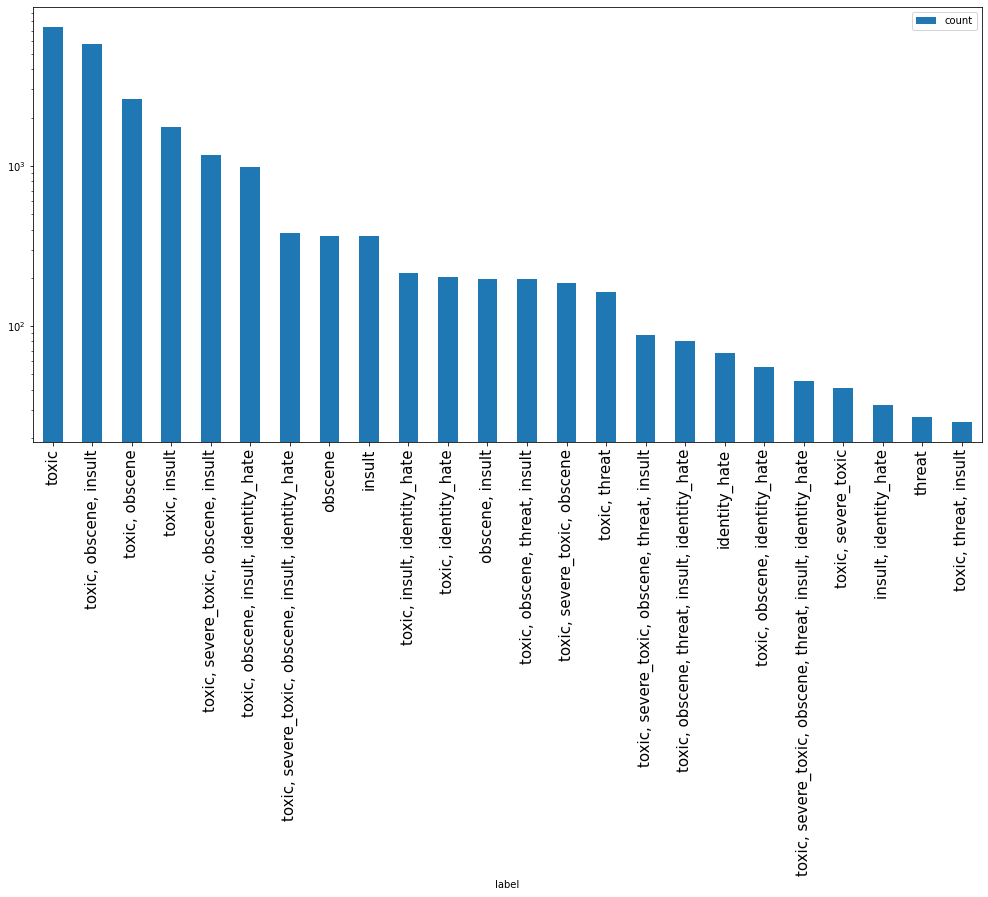

In [6]:
visualize.create_toxicity_barplot(df_train)

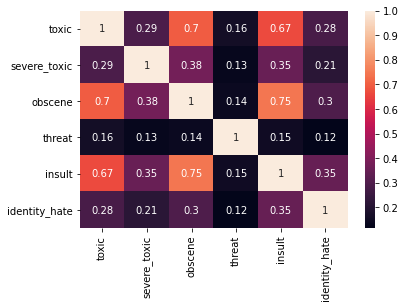

In [7]:
visualize.create_corr_plot(df_train)

By looking at the labels, we can see that roughly 90% of the 200K+ comments are nontoxic. The remaining unsavory comments have a combination of labels including toxic, severe_toxic, obscene, insult, identity_hate, and threat. The bulk of the comments are vanilla toxic and the next most common are comments that are both toxic with a combination of obscence and/or insult. Interestingly, about 4% of the 22.5K unsavory comments do not have a toxic label; they are a combination of obscene and insult. Overall, toxic is the label to predict, though it will be interesting to see how different types of models do with different flavors of toxicity.

## Preprocessing steps

In [8]:
word_counter = visualize.create_word_counter(df_train)


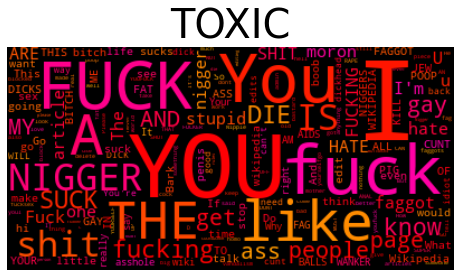

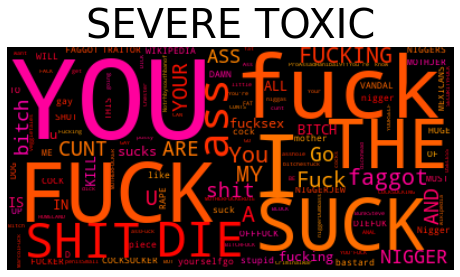

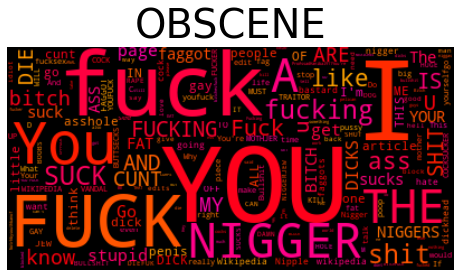

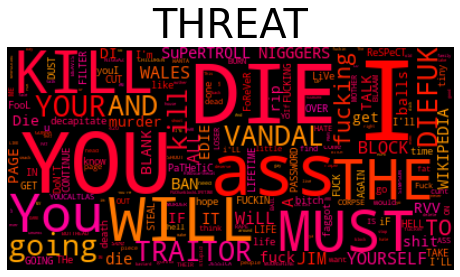

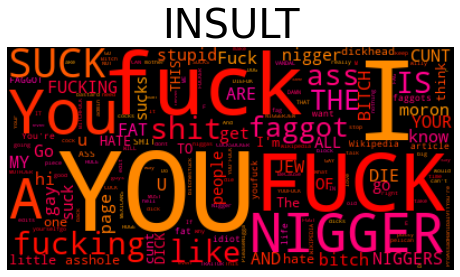

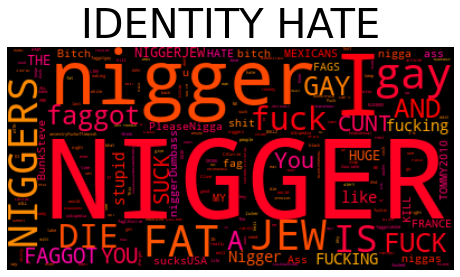

In [9]:
visualize.create_wordcloud(word_counter)

Overall, we can see a lot of disturbing words for the word clouds in each category. Identity Hate has more specific attacks against race, religion, sexual orientation, and gender. Threat has more hate-related verbs and seems to be a bit different in its words from all the other categories. The most represented categories in the dataset are toxic/obscene/insult. Overall, these categories seem to have similar highly represented words. We will now see if these common words translate into highly predictive features. 

2980
4804


,count
TRACKED,1
USERPAGE,1
SPOIL,1
moments,1
memorable,1
Moments,1
HIPPIE,1
DON,1
wazoo,1
smoke,1


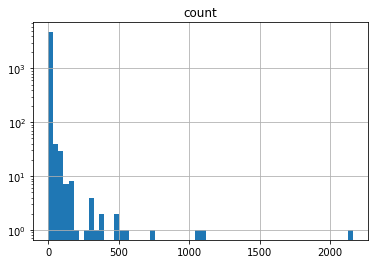

In [10]:
#Quantify how much misspellings and long tail might be affecting results
word_counter['threat'].hist(bins=60)
plt.yscale('log')
print(sum(word_counter['threat']['count']==1))
print(len(word_counter['threat']))
threat = word_counter['threat']
threat.tail(n=999)



We will drop the other columns and approach this problem as a Binary Classification Problem and also we will have our exercise done on a smaller subsection of the dataset(only 12000 data points) to make it easier to train the models

## Sample data

In [11]:
df_train = data.load(constants.INPUT_PATH, filter=True)

## Explore Traditional Text Preprocessing Techniques

In [12]:
#Explore regex cleanups, # of unknown words, and lemmatization

## Create train and test sets

In [13]:
xtrain, xvalid, ytrain, yvalid = model.make_train_test(df_train)

## Create Features

In [14]:
count_train, count_valid = model.apply_count_vectorizer(xtrain, xvalid)


## Train Naive Bayes Model

In [15]:
nb_classifier = model.run_naive_bayes_classifier(count_train, count_valid, ytrain, yvalid)
pred = nb_classifier.predict(count_valid)
pred_proba = nb_classifier.predict_proba(count_valid)[:,1]


Average precision-recall score: 0.50
[[39011  1422]
 [ 1296  2981]]
Accuracy Score: 0.94


(array([0.00000000e+00, 7.41968194e-04, 7.41968194e-04, ...,
        9.99332229e-01, 9.99851606e-01, 1.00000000e+00]),
 array([0.        , 0.05167173, 0.05213935, ..., 1.        , 1.        ,
        1.        ]),
 array([0.09656153, 0.09654114, 0.09654332, ..., 0.88142292, 0.88047809,
        1.        ]))

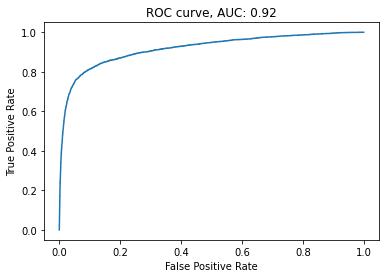

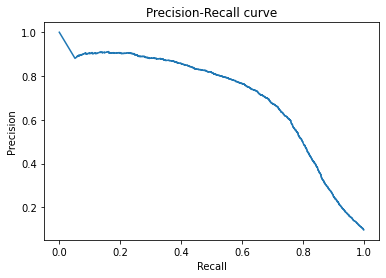

In [16]:
import toxicity
toxicity.metrics.run_metrics(pred, pred_proba, yvalid, visualize=True)

## Use Tfidf for the features

In [19]:
count_train_idf, count_valid_idf = model.apply_tfidf_vectorizer(xtrain, xvalid)


In [21]:
nb_classifier = model.run_naive_bayes_classifier(count_train_idf, count_valid_idf, ytrain, yvalid)
pred = nb_classifier.predict(count_valid_idf)
pred_proba = nb_classifier.predict_proba(count_valid_idf)[:,1]


Average precision-recall score: 0.21
[[40388    45]
 [ 3682   595]]
Accuracy Score: 0.92


(array([0.        , 0.        , 0.        , ..., 0.99908491, 0.99913437,
        1.        ]),
 array([0.00000000e+00, 2.33808744e-04, 3.27332242e-03, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([0.09688088, 0.09686042, 0.09686261, ..., 1.        , 1.        ,
        1.        ]))

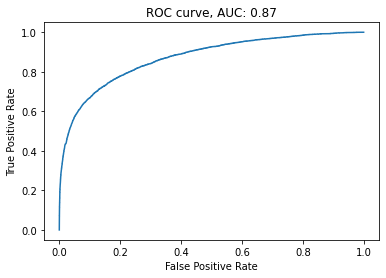

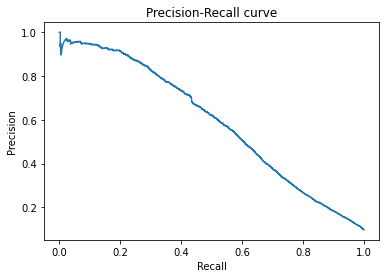

In [22]:
toxicity.metrics.run_metrics(pred, pred_proba, yvalid, visualize=True)